In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4 as nc
import datetime

In [ ]:
def readgrid(path="/work/bb1070/b381019/Input/",name="domain3_DOM02.nc"):
        """
        read Icon grid via xarray, converts radians to degrees
        arguments 
            str(path): path to gridfile
            str(name): name of gridfile
        """
        
        rad2deg = 180.0/np.pi
        deg2rad = np.pi/180
        ds_grid = ( xr.open_dataset(path+name))
        # convert grid from radians to degrees
        ds_grid['clon'] = ds_grid['clon']*rad2deg
        ds_grid['clat'] = ds_grid['clat']*rad2deg
        ds_grid['clon_vertices'] = ds_grid['clon_vertices']*rad2deg
        ds_grid['clat_vertices'] = ds_grid['clat_vertices']*rad2deg
        return ds_grid

In [11]:
def sliceline(npoints,deg_E_start,deg_E_end,deg_N):
    """
    arguments:
        npoints,deg_N_start,deg_N_end,deg_E
    makes n points following a line from start to end
    start and endpoint HAVE to be somewhere inside the grid to prevent artifacts
    """
    lats = np.linspace(deg_E_start,deg_E_end,npoints)
    lons = np.repeat(deg_N,npoints)
    return np.rot90(np.array([lats,lons]))

In [12]:
def NN_gridpoints(sliceline_points,grid):
    """
    performs NN Mapping between grid and specified points
    returns list of closest gridpoint indices
    arguments:
        grid: gridfile ,read in via readgrid()
        sliceline_points: output of sliceline or point[lon,lat] you want the nearest gridpoint of
    """
    gridpoints = np.zeros(len(sliceline_points))
    
    for i in range(len(sliceline_points)):
        gridpoints[i] = np.argmin((grid["clon"].values[:]-sliceline_points[i,0])**2
                                + (grid["clat"].values[:]-sliceline_points[i,1])**2)
    gridpoints=np.array(gridpoints,dtype=int)
    return gridpoints

In [44]:
def plot_map(grid,points,NN_gridpoints):  
    """
    show visually where the vertical slice is and which gridpoints are used
    arguments:
        grid: Icongrid, containing clat and clon
        points: points of the line where the vertical slice will take place
        NN_gridpoints: Nearest Neighbouring Points on Grid to Points of vertical slice
    
    """
    plt.figure(figsize=[16,9],facecolor="white")

    #plot map
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.stock_img()
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS.with_scale('50m'))
    label=ax.set_extent([min(grid['clon'].values),max(grid['clon'].values)
                   ,min(grid['clat'].values),max(grid['clat'].values)])

    label=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=2, color='black',draw_labels=True, alpha=0.5, linestyle='--')
    plt.title("position of vertical slice(red) and corresponding gridpoints(blue)")
    
    #plot grid and position of vertical slice
    #plt.plot(grid['clon'].values[::5],grid['clat'].values[::5],"k,")
    plt.plot(points[:,0],points[:,1],"r+-")

    #plot NN-mapped gridpoints used for the slice
   
    plt.plot(grid['clon'].isel(cell=gridpoints).values,grid['clat'].isel(cell=gridpoints).values,'bx')
    
    return

In [14]:
def make_slice(data,height,gridpoints,t,var):
    """
    Arguments:
        data,height,gridpoints,t,var
        gets plotable datapoints for the vertical slice from the whole Dataset
    
    """
    height_level_max=30
    y_axis=np.rot90(height.isel(height=slice(-height_level_max-1,-1),ncells=gridpoints,time=t)["HHL"].values).flatten()
    ground=height.isel(ncells=gridpoints,time=t,height=-1)["HHL"].values
    dust = np.rot90(data.isel(height=slice(-height_level_max-1,-1),ncells=gridpoints,time=t)[var].values).flatten()
   
    x_data = np.arange(0,len(gridpoints))
    x_axis = np.repeat(x_data,height_level_max)

    return x_axis ,y_axis, dust, x_data, ground,t 

/sw/spack-rhel6/anaconda3-2020.02-dqbodz/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


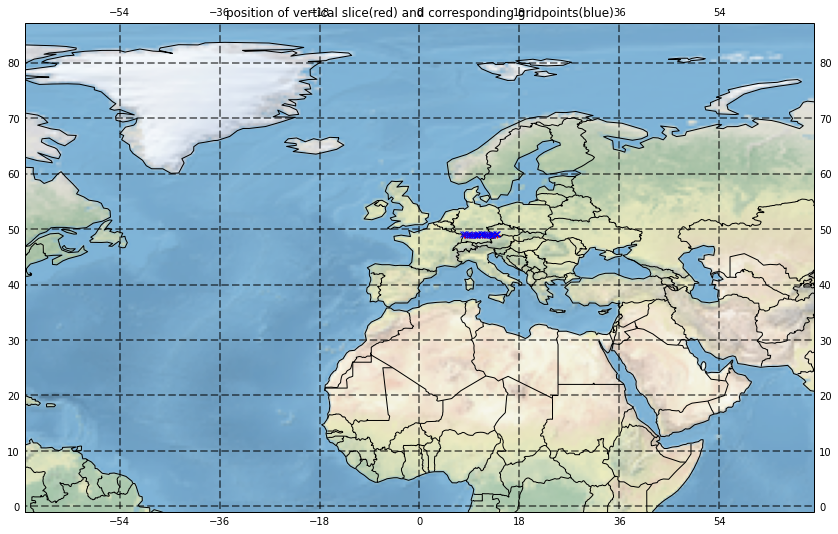

In [24]:
#how to use
deg_E_start = 8
deg_E_end = 14
deg_N = 49
npoints = 21
grid = readgrid(path="/mnt/lustre01/work/bb1070/b380982/Dust/Emiss/" ,name='icon_grid_0051_R02B07_N02.nc')
line = sliceline(npoints,deg_E_start,deg_E_end,deg_N)
gridpoints = NN_gridpoints(line,grid)
plot_map(grid,line,gridpoints)

In [22]:
data = xr.open_dataset('/mnt/lustre01/work/bb1070/b380982/Dust/Daten/090321/iefff04150000.nc')
height = xr.open_dataset('/mnt/lustre01/work/bb1070/b380982/Dust/Daten/hhl.nc')

Text(0, 0.5, 'Height in m')

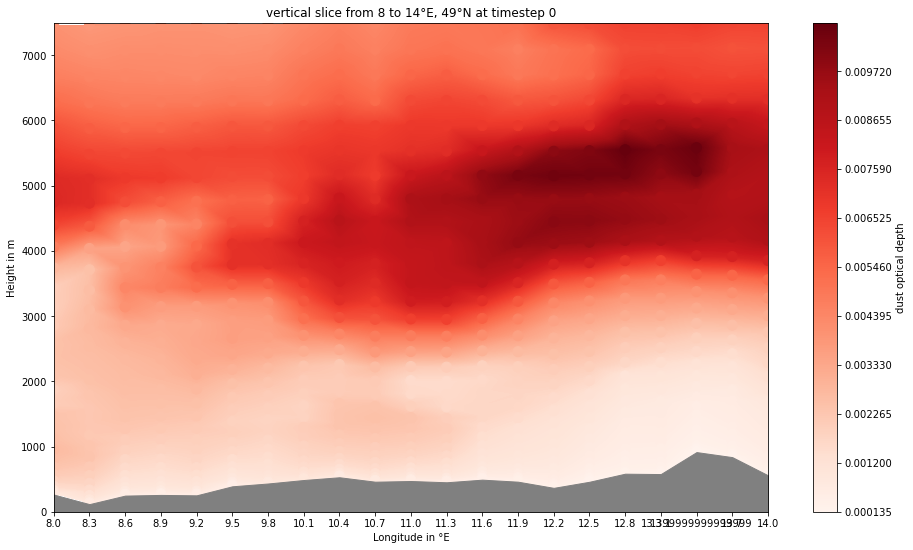

In [42]:
x_axis ,y_axis, dust, x_data, ground,t = make_slice(data,height,gridpoints,0,'AOD_DUST')
plt.figure(figsize=(16,9),facecolor='white')
n = 400 #correction Faktor to prevent artifacts in tricontourf. makes horizontal distance between points similar to vertical distance, which is required for the interpolation of colors between the gridpoints

plt.title('vertical slice from {} to {}°E, {}°N at timestep {}'
          .format(deg_E_start,deg_E_end,deg_N,t))

#select between scatter, contour or both (both is helpful to check if contour contains artifacts to then adjust n)
cmap1 =plt.tricontourf(x_axis*n,y_axis,dust,cmap="Reds",vmin=0,vmax=max(dust),levels=1000)
plt.scatter(x_axis*n,y_axis,c=dust,cmap="Reds",vmin=0,vmax=max(dust),marker='o',s=100)

plt.colorbar(cmap1, label='dust optical depth')
ticks=plt.xticks(x_data*n,np.linspace(deg_E_start,deg_E_end,npoints))
plt.fill_between(x_data*n,ground[::-1],color='grey')
plt.ylim(0)
plt.xlabel('Longitude in °E')
plt.ylabel('Height in m')

In [28]:
data['AOD_DUST']

<xarray.DataArray 'AOD_DUST' (time: 1, height: 60, ncells: 254588)>
[15275280 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2021-03-13T15:00:00
  * height   (height) float64 1.5 2.5 3.5 4.5 5.5 ... 56.5 57.5 58.5 59.5 60.5
Dimensions without coordinates: ncells
Attributes:
    long_name:                    Diagnostic mineral dust optical depth
    units:                        Numeric
    param:                        102.20.0
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  1
    institution:                  DWD

In [41]:
?plt.scatter